
✅ Files loaded successfully!

📊 Dataset Shapes:
 • Energy Consumption       : (14400, 4)
 • Site Information         : (10, 10)
 • Solar Power              : (14400, 12)
Correlation: -0.659746414567014, P-value: 0.0
['Site Name', 'Day', 'Hour', 'Solar Zenith Angle', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Relative Humidity', 'DHI', 'DNI', 'GHI', 'Energy Output(kWh)', 'Total Energy(kWh)', 'Site Id', 'diesel power(kW)', 'battery capacity (Ah)', 'rated voltage（V）', 'battery charge coefficient', 'battery discharge coefficient', 'init SOC', 'DOD', 'grid power(kW)', 'grid outage plan']


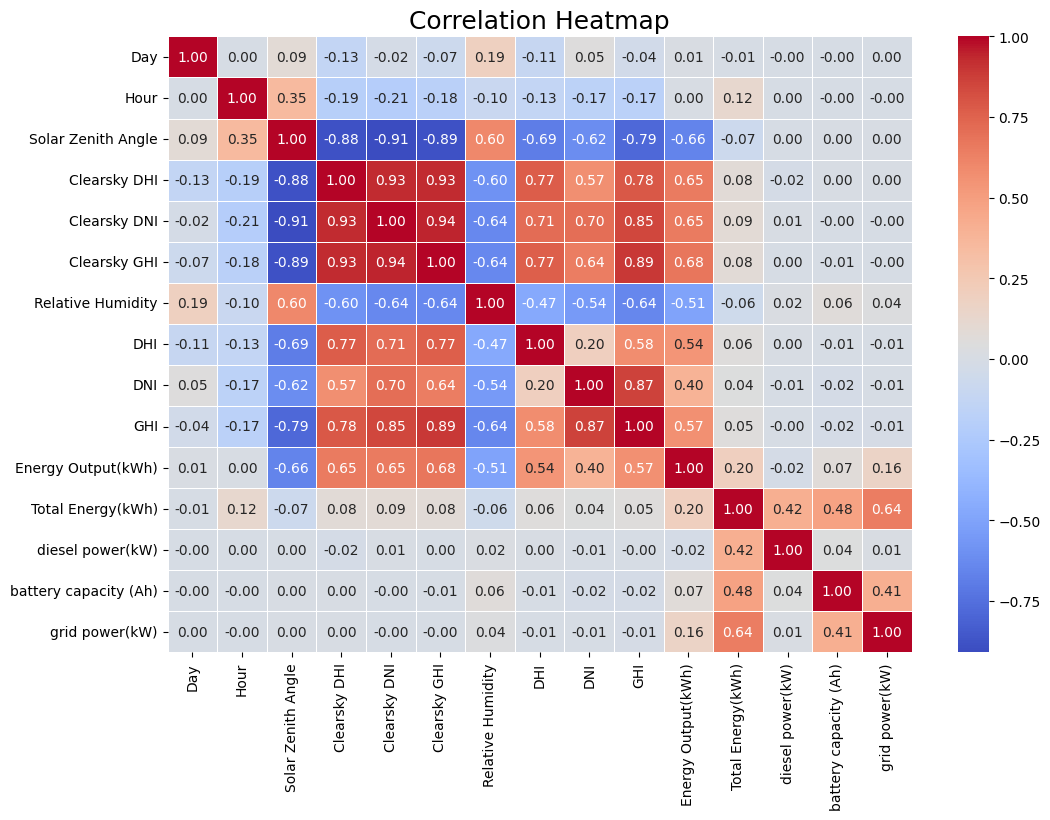

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, ...)
Test RMSE: 1.7440
Test MAE: 1.0391
Test R-squared: 0.8070

🔍 Feature usage check:
Features in training data: ['Site Name', 'time', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI', 'Relative Humidity', 'DHI',

In [ ]:
# Strategy Implemented Code
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from scipy.stats import pearsonr
# display all columns in a dataframe
pd.set_option('display.max_columns', None)

# 📄 Paths to your CSVs on Drive
energy_path    = '/content/drive/My Drive/energy consumption.csv'
site_info_path = '/content/drive/My Drive/site information and grid outage.csv'
solar_power_path = '/content/drive/My Drive/solar power and weather condition.csv'

# 📄 Read CSVs
energy_consumption = pd.read_csv(energy_path)
site_info          = pd.read_csv(site_info_path)
solar_power        = pd.read_csv(solar_power_path)

# ✅ Output 1
print("\n✅ Files loaded successfully!\n")
print("📊 Dataset Shapes:")
print(f" • Energy Consumption       : {energy_consumption.shape}")
print(f" • Site Information         : {site_info.shape}")
print(f" • Solar Power              : {solar_power.shape}")
site_info.columns
energy_consumption.head()
energy_consumption.columns
solar_power.head()
site_info.head()
solar_power.columns
energy_consumption.isnull().sum()
site_info.isnull().sum()

# Merge datasets
df_merged = solar_power.merge(energy_consumption, on=['Site Name', 'Day', 'Hour'], how='left')
df = pd.merge(df_merged, site_info, left_on='Site Name', right_on='Site Id')

df.head()
df_merged.columns
# Sort DataFrame by 'Site Name' in natural order
df = df.sort_values(by='Site Name', key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))

# Fill missing values
df.ffill(inplace=True)
df.isnull().sum()
df.shape
df.isna().sum()
df.columns

# Select only the numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# Calculate correlations
correlations = numeric_df.corr()
correlations[['Energy Output(kWh)', 'Total Energy(kWh)', 'battery capacity (Ah)', 'grid power(kW)', 'diesel power(kW)']]

# Correlation check
corr, p_value = pearsonr(df['Energy Output(kWh)'], df['Solar Zenith Angle'])
print(f"Correlation: {corr}, P-value: {p_value}")

# Print column names to verify
print(df.columns.tolist())

# Update the exclude_columns list with verified column names
exclude_columns = ['Site Name', 'Site Id', 'rated voltage（V）', 'battery charge coefficient',
                   'battery discharge coefficient', 'init SOC', 'DOD']

# Exclude non-numeric columns and those explicitly mentioned
numeric_df = df.drop(columns=exclude_columns).select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=18)
plt.show()

# Encode categorical variables
le = LabelEncoder()
df['Site Name'] = le.fit_transform(df['Site Name'])

# Create time feature
df['time'] = df['Hour'] + (df['Day'] - 1) * 24

# --- ✅ Add Day of the Week Name ---
day_map = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
           5: 'Friday', 6: 'Saturday', 7: 'Sunday'}

# Features & target (🔹 Removed Energy_Cost as per master’s instruction)
X = df[['Site Name', 'time', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
        'Relative Humidity', 'DHI', 'DNI', 'GHI']]
y = df['Energy Output(kWh)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
xgboost_reg = xgb.XGBRegressor(objective='reg:squarederror')
xgboost_reg.fit(X_train, y_train)

# GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'alpha': [0, 10, 50]
}
grid_search = GridSearchCV(estimator=xgboost_reg, param_grid=param_grid, cv=5,
                           scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(best_model)

# Evaluation metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test R-squared: {r2_test:.4f}")

# --- Check Feature Importance ---
print("\n🔍 Feature usage check:")
print("Features in training data:", list(X.columns))
if hasattr(best_model, "coef_"):
    for feature, coef in zip(X.columns, best_model.coef_[0]):
        print(f"{feature}: {coef:.4f}")
elif hasattr(best_model, "feature_importances_"):
    for feature, importance in zip(X.columns, best_model.feature_importances_):
        print(f"{feature}: {importance:.4f}")
else:
    print("Model type does not support direct feature importance check.")

# Predict all
all_features = X.copy()
predictions = best_model.predict(all_features)

# --- Strategy Implementation ---

# Convert hourly to 15-min slots
df = df[df['Day'] <= 7].copy()
df = df.loc[df.index.repeat(4)].reset_index(drop=True)
df['Quarter'] = df.groupby(['Site Name', 'Day', 'Hour']).cumcount()
df['time'] = (df['Day'] - 1) * 96 + df['Hour'] * 4 + df['Quarter']

# --- ✅ Site-wise battery parameters mapping ---
site_params = {}
for idx, row in site_info.iterrows():
    site_id = row['Site Id']
    site_params[site_id] = {
        'battery_capacity': row['battery capacity (Ah)'],
        'init_soc': row['init SOC'] / 100.0,
        'dod': row['DOD'] / 100.0
    }

# Track per-site SOC and energy
site_soc = {site_id: site_params[site_id]['init_soc'] for site_id in site_params.keys()}
site_batt_energy = {site_id: site_params[site_id]['battery_capacity'] * site_params[site_id]['init_soc'] for site_id in site_params.keys()}

# Output DataFrame -- now includes SOC
records = []  # store each row as a dictionary

# --- Cost-Aware Strategy with DoD Logic ---
for index, row in df.iterrows():
    site_id = row['Site Id']
    time = row['time']
    energy_demand = row['Total Energy(kWh)']
    solar_supply = row['Energy Output(kWh)']

    battery_capacity = site_params[site_id]['battery_capacity']
    dod = site_params[site_id]['dod']
    min_allowed_energy = battery_capacity * (1 - dod)

    battery_energy = site_batt_energy[site_id]
    soc = battery_energy / battery_capacity

    # Initialize
    grid_on = False
    diesel_on = False
    solar_on = False
    battery_on = False
    remaining_demand = energy_demand

    # Step 1: Prioritize Solar
    if solar_supply > 0 and remaining_demand > 0:
        solar_on = True
        if solar_supply >= remaining_demand:
            charge_amount = min(solar_supply - remaining_demand, battery_capacity - battery_energy)
            battery_energy += charge_amount
            remaining_demand = 0
        else:
            remaining_demand -= solar_supply

    # Step 2: Use Battery (respect DoD limit)
    available_battery_discharge = max(0, battery_energy - min_allowed_energy)
    if remaining_demand > 0 and available_battery_discharge > 0:
        discharge_amount = min(remaining_demand, available_battery_discharge)
        battery_on = True
        battery_energy -= discharge_amount
        remaining_demand -= discharge_amount

    # Step 3: Cost-aware choice between Grid & Diesel
    is_grid_outage = row['grid outage plan'][row['Hour']]
    grid_power = row['grid power(kW)']
    diesel_power = row['diesel power(kW)']

    if remaining_demand > 0:
        if not is_grid_outage and grid_power > 0:
            grid_cost = grid_power * 5
            diesel_cost = diesel_power * 15
            if grid_cost <= diesel_cost:
                grid_on = True
                remaining_demand = max(0, remaining_demand - grid_power)
            else:
                diesel_on = True
                remaining_demand = max(0, remaining_demand - diesel_power)
        else:
            if diesel_power > 0:
                diesel_on = True
                remaining_demand = max(0, remaining_demand - diesel_power)

    # Step 4: If still unmet → diesel last resort
    if remaining_demand > 0 and not diesel_on:
        diesel_on = True

    # Update SOC & save state
    site_batt_energy[site_id] = battery_energy
    site_soc[site_id] = battery_energy / battery_capacity

    # Append decision
    records.append({
        'site': site_id,
        'time': time,
        'grid': grid_on,
        'diesel': diesel_on,
        'solar': solar_on,
        'battery': battery_on,
        'soc': site_soc[site_id]
    })

# ✅ Sort by site and time before saving
strategy_df = pd.DataFrame(records)
strategy_df = strategy_df.sort_values(by=['site', 'time']).reset_index(drop=True)
strategy_df['day_name'] = df['Day'].map(day_map)

# ✅ Convert numeric site ids back to site1, site2...
strategy_df['site'] = "site" + (strategy_df['site'].str.extract(r'(\d+)')[0]).astype(str)

strategy_df.to_csv('strategy_submission.csv', index=False)

print("🔋 New cost-aware strategy generated successfully with solar + battery + DoD logic (SOC tracked)!")
print(predictions.size)

In [ ]:
!jupyter nbconvert --to html New_Code_with_Implementation_final.ipynb

[NbConvertApp] Converting notebook New_Code_with_Implementation_final.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 563959 bytes to New_Code_with_Implementation_final.html
